In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
import h5py
import numpy as np
import pandas as pd
import os,sys
import glob
from scipy import stats
import random
import gempy as gp
from gempy.bayesian.fields import probability, information_entropy, fuzziness, total_model_entropy

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use(['seaborn-talk'])

sys.path.append('../models/20210319_MC_no_middle_filling/')

print(f"Run mit GemPy version {gp.__version__}")

Run mit GemPy version 2.2.9


In [2]:
def c_rmse(predicted, target):
    rm_sq_diff = np.sqrt((predicted.sub(target, axis=0)**2).mean())
    return rm_sq_diff

def rejection(rmse, rnseed=np.random.seed(0), verbose=True, reference=0):
    rnseed
    Ref = rmse[reference]
    accept = []
    P = []
    k = 0
    for i in range(1,len(rmse)):
        if rmse[i] < Ref:
            Ref = rmse[i]
            accept.append(i)
            
        elif random.random() < np.exp(-(rmse[i] - Ref)/(u_g)):
            P.append(np.exp(-(rmse[i] - Ref)/(u_g)))
            Ref = rmse[i]
            accept.append(i)
            k +=1
    if verbose==True:
        print(f"{len(accept)} realizations were accepted.")
    return accept, P

def fahrenheit_to_celsius(temp_fahrenheit, difference=False):
    if not difference:
        return (temp_fahrenheit - 32) * 5 / 9
    else:
        return temp_fahrenheit * 5 / 9
        
def extTui(datafile, dimension=3, direction='x'):
    f = h5py.File(datafile,'r')
    z, y, x = f['temp'].shape
    if dimension==3:
        temp = f['temp'][:,:,:]
        uindex = f['uindex'][:,:,:]
    elif dimension==2:
        if direction=='x':
            temp = f['temp'][:,:,x//2]
            uindex = f['uindex'][:,:,x//2]
        elif direction=='y':
            temp = f['temp'][:,y//2,:]
            uindex = f['uindex'][:,y//2,:]
        elif direction=='z':
            temp = f['temp'][z//2,:,:]
            uindex = f['uindex'][z//2,:,:]
    return temp,uindex

# Rejection algorithm based on random walk
We created a tiny ensemble of the 10 different models for gravity and in SHEMAT-Suite, which we created before and will use a rejection algorithm, loosely based on the Metropolis acceptance probability to get a posterior ensemble of models.  
This acceptance probability is defined as:  

$$ \alpha(x_{t-1},z) = \begin{cases} min\big(\frac{p(z)}{p(x_{t-1})},1\big), & \text{if } p(x_{t-1}) > 0\\
1, & \text{if } p(x_{t-1}) = 0 \end{cases} $$  

A different approach would be to assess the missfit (as RMS error) of each realisation.  

$$ \alpha(x_{t-1},z) = \begin{cases} exp\big(-\frac{S(z) - S(x_{t-1}) }{u_T}\big), & \text{if } S(z) > S(x_{t-1})\\
1, & \text{otherwise }  \end{cases} $$  

We will use the second approach for now...also because we wrote it in the abstract.  
As discretization error, we take a value from Elison(2015), $u_{T-discr} = 0.7$ K  

Using Gauss error propagation, we assess a potential error for the realisations.  

$$ u_T = \sqrt{\big(\frac{\partial T}{\partial x_1}u_1 \big)^2 + ... + \big(\frac{\partial T}{\partial x_n}u_n \big)^2} $$

Literature sources for log-errors:
_The lower part of the disturbed log profile (below the cross-over point) was rotated to match these corrected tempera-tures. In the upper part of the profile, the same correction as for method A was applied. The quality of this correction method strongly depends on the correct calculation of the lowermost profile temperatures. According to Förster (2001), most of the corrected tem-peratures have errors of ± 3 to 5 K._ https://doi.org/10.1186/s40517-020-00181-w  


 _The effective accuracy of commercial temperature logs is ±0.5ºC (Blackwell and Spafford, 1987)._  http://www.sprensky.com/publishd/temper2.html  
 
 _More normal accuracies are +- 0.25 °C over 0-200 °C_ Keith Geothermal Energy lecture  
 
 For errors as a function of e.g. logging speed, measurement response time etc, look https://doi.org/10.1016/j.petrol.2020.107727

In [3]:
# import DTM
dtm = np.load('../../models/Graben_base_model_topography.npy')

In [4]:
# load base model
model_path = '../../models/2021-06-04_POC_base_model/'

geo_model = gp.load_model('POC_PCT_model', 
                          path=model_path, recompile=False)

Active grids: ['regular']
Active grids: ['regular' 'topography']


In [5]:
# get delx and dely of the model, so cell sizes
delx = geo_model._grid.regular_grid.dx
dely = geo_model._grid.regular_grid.dy
delz = geo_model._grid.regular_grid.dz

In [6]:
# import gravity data and borehole locations
g_data = pd.read_csv('../../models/2021-06-16_grav_of_POC_base_model.csv')
bhole = np.array([[31, 14],
                 [78, 22],
                 [53, 34],
                 [49, 44]])

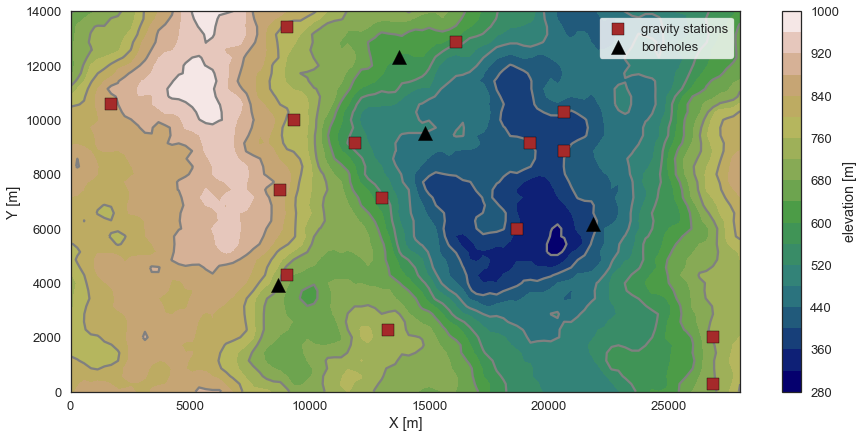

In [7]:
# plot the map
fig = plt.figure(figsize=[15,7])
cs = plt.contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth')
plt.contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
plt.scatter(g_data['X'], g_data['Y'], marker='s', s=150, c='brown', edgecolor='k', 
            label='gravity stations', zorder=2)
plt.scatter(bhole[:,0]*delx, bhole[:,1]*dely, marker='^', s=200, c='k', label='boreholes',
           zorder=3)
plt.colorbar(cs, label='elevation [m]')
plt.legend(frameon=True)
plt.xlabel('X [m]')
plt.ylabel('Y [m]');
#fig.savefig('../imgs/Model_topography_and_grav_stations.png', dpi=300, bbox_inches='tight')

## Load the Lithology Blocks
First let's load the lithology block of all 1000 models, looking at the probabilities of the graben unit and at the model entropy.

In [8]:
# load and calculate Probability and Entropy using GemPy bayesian field functions
ens = np.load('../../data/outputs/MCexample_10realizations.npy')
prior_prob = probability(ens)
prior_entr = information_entropy(prior_prob)

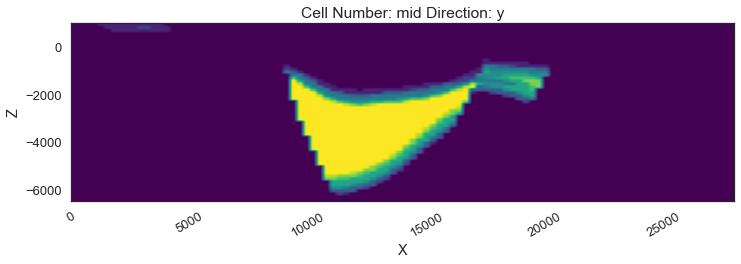

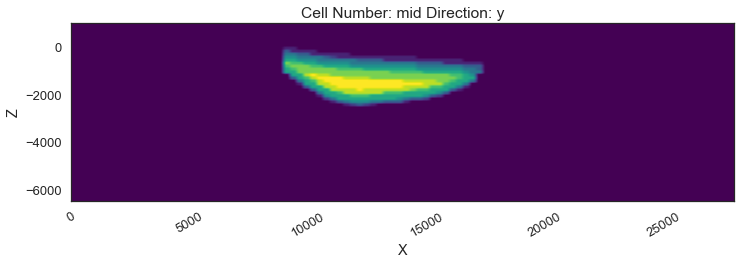

In [9]:
layer = 5
# upper filling
gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_prob[layer],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None})
# lower filling
gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_prob[layer-1],
                  kwargs_regular_grid={'cmap': 'viridis',
                                        'norm': None});

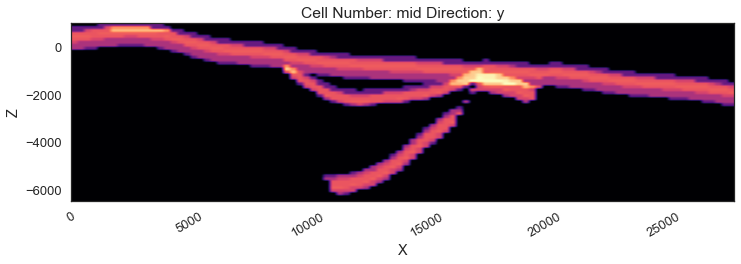

In [10]:
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=prior_entr,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None,
                                      'colorbar': True}
                  )
#plt.savefig('../imgs/POC_prior_IE.png', dpi=300, bbox_inches='tight')

The Information entropy plot shows where the maximal Uncertainty is in our model, i.e. where the contacts are between the graben units and the basement. A lot of uncertainty is visible in the right part of the model (between around 16000 and 20000), where the main graben unit may or may not be present.

# Gravity rejection
In a first stage, we take a look at the gravity signal of each realization. The gravity signal is "recorded" at each of the squares you see in the plot above. Comparing the recorded gravity signals of each realization with the ones of the base model (which we regard as the "true" observations), we can differentiate between fitting and non-fitting ensemble members.

In [48]:
g_simu = pd.read_csv('../../data/outputs/MCexample_10grav.csv')

In [49]:
g_simu.head()

,Real_0,Real_1,Real_2,Real_3,Real_4,Real_5,Real_6,Real_7,Real_8,Real_9
0,-533.673251,-532.673751,-534.038468,-533.143688,-534.590898,-533.483330,-533.631910,-534.186293,-533.873075,-534.097548
1,-533.469712,-531.718800,-534.009147,-532.039845,-534.347122,-533.275549,-533.126723,-534.074861,-533.600943,-534.057343
2,-529.378333,-529.036879,-528.462048,-529.954048,-525.608291,-527.275759,-528.747860,-527.931698,-527.359286,-526.207417
3,-533.691969,-531.952383,-534.055335,-532.632034,-533.845509,-532.641484,-533.093253,-534.387168,-533.574950,-533.370863
4,-533.735260,-532.092981,-534.197462,-532.649674,-533.692935,-532.890857,-533.219227,-534.262520,-533.789781,-533.422763


In [50]:
add_noise = True
if add_noise==True:
    np.random.seed(27)
    noise = np.random.normal(0, 1., size=15)
    g_data_noise = g_data.copy()
    g_data_noise['grav'] = g_data_noise['grav'] + noise
    print(np.mean(noise))
    u_g = np.mean(noise)
elif add_noise==False:
    u_g = 0.5

0.32409402260706643


In [51]:
#calculate stdeviation and mean of the prior ensemble
g_simu_stdev = g_simu.std(axis=1)
g_simu_mean = g_simu.mean(axis=1)

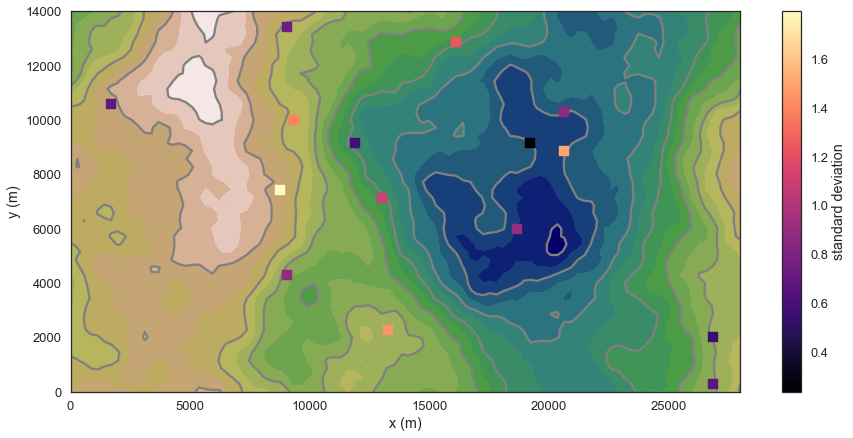

In [52]:
fig = plt.figure(figsize=[15,7])
cs = plt.contourf(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],20, cmap='gist_earth')
plt.contour(dtm[:,:,0], dtm[:,:,1], dtm[:,:,2],10, colors='gray', zorder=1)
cs = plt.scatter(g_data['X'], g_data['Y'], c=g_simu_stdev, marker='s', 
                 s=100, zorder=2, cmap='magma')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar(cs, label='standard deviation');

In [53]:
seed = random.seed(7)
rmse = c_rmse(g_simu, g_data['grav'])
accept, P = rejection(rmse=rmse, rnseed=seed)

5 realizations were accepted.


In [54]:
accepted_reals = ens[accept, :]
grav_prob = probability(accepted_reals)
grav_entr = information_entropy(grav_prob)

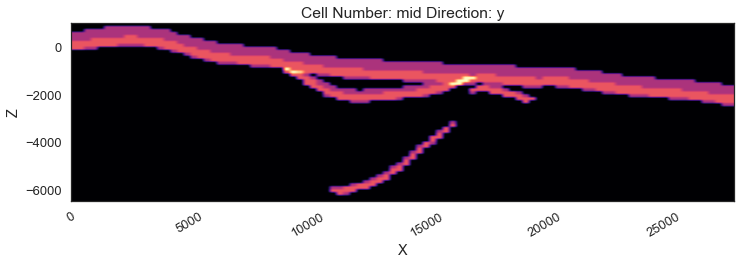

In [55]:
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=grav_entr,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )

In [56]:
np.save('../../data/outputs/lith_blocks_accepted.npy', accepted_reals)
np.savetxt('../../data/outputs/accepted_realizations_ID.txt', accept, fmt='%d')

## Temperature rejection
The black triangles in the Map plot are the locations from 4 different boreholes in the model. Temperature data from these boreholes is now used in a similar fashion to further reduce the model to realizations, which now fit both the gravity and the temperature signal.

Similarly to the previous tutorial, where we saved the base model as a SHEMAT-Input file, we now do the same with the accepted realizations:

In [57]:
f = h5py.File('../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_temp_final.h5','r')

In [58]:
z,y,x = f['uindex'].shape

In [59]:
# define uT
T_error = 0.25 # temperature error tool accuracy
s_error = fahrenheit_to_celsius(1.25, difference=True) # sensor response time of 2 sec and 1 year after drilling
l_error = fahrenheit_to_celsius(1.25, difference=True) # logging speed of 20/ft after 1 year
d_error = 1.0 # estimated temperature error by discretization
#u_T = np.sqrt(T_error[0]**2 + T_error[1]**2 + T_error[2]**2 + T_error[3]**2 + d_error**2)
#u_T = np.sum(T_error**2)/4
u_T = np.sqrt(T_error**2 + s_error**2 + l_error**2 + d_error**2)
print(u_T)

1.4237296698599444


In [34]:
# load Simulation outputs. Those outputs get written by SHEMAT-Suite if runmode = 1
outp_path = '../models/20210319_MC_no_middle_filling/SHEMAT_MC/'
#accepted = accept
accepted = np.loadtxt('../models/20210319_MC_no_middle_filling/accepted_realizations_01042021').astype(int)
diffs = np.loadtxt(outp_path+'PCT_MC_1dat_cor_final.dat',skiprows=3,usecols=(8,),dtype=float)
for i in accepted[1:]:
    n = np.loadtxt(outp_path+f'PCT_MC_{i}dat_cor_final.dat',skiprows=3,usecols=(8,),dtype=float)
    diffs=np.vstack([diffs,n])

In [35]:
# calculate RMSE of each realisation.
n = diffs.shape[1] # as we have 4 data points for temperature

diffs_sq = diffs**2
ssr = diffs_sq.sum(axis=1)
rmse = np.sqrt((diffs_sq.sum(axis=1)/n))

In [36]:
# this is a matrix with all vectors. First 96 columns are differences of the wells, then the column is the SSR, 
# final column is RMSE
tot_diffs = np.column_stack((diffs,ssr,rmse))
print(tot_diffs.shape)
# add index to the realizations
ind = np.array(range(tot_diffs.shape[0]))
tot_diffs = np.column_stack((tot_diffs,accepted))

(626, 130)


## Rejection sampling
we now start with a random sample and go randomly through the pool, accepting and rejecting realizations.
The algorithm starts with one refrence sample `Ref`. Then, iteratively, samples (= realizations) get accepted, rejected based on their RMSE values. That is why we use the 6th column of `tot_diffs`. Alternatively, one could also just use the `rmse` array.

In [37]:
# Chronological implemntation - start von 1 bis N 
# Can be used here, if samples generated are already in a random order and not correlated.
# That is usually the case with GemPy exports to SHEMAT-Suite.
random.seed(42)
col = 129
Ref = tot_diffs[0,col]
accept = []
P = []
k=0
for i in range(1,tot_diffs.shape[0]):
    if tot_diffs[i,col] < Ref:
        Ref = tot_diffs[i,col]
        accept.append(i)
        
    elif random.random() < np.exp(-(tot_diffs[i,col] - Ref)/(u_T)):
        P.append(np.exp(-(tot_diffs[i,col] - Ref)/(u_T)))
        Ref = tot_diffs[i,col]
        accept.append(i)
        k += 1
print(len(accept))

507


In [38]:
accepted_reals_T = accepted_reals[accept, :]
grav_T_prob = probability(accepted_reals_T)
grav_T_entr = information_entropy(grav_T_prob)

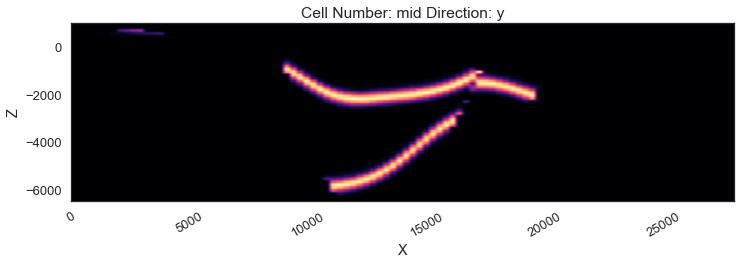

In [39]:
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=grav_T_entr,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )
plt.savefig('../imgs/POC_grav_temp_posterior_IE.png', dpi=300, bbox_inches='tight')

In [48]:
np.savetxt('../models/20210319_MC_no_middle_filling/accepted_after_temp_rejection', accept)

## Rejection sampling
we now start with a random sample and go randomly through the pool, accepting and rejecting realizations.
The algorithm starts with one refrence sample `Ref`. Then, iteratively, samples (= realizations) get accepted, rejected based on their RMSE values. That is why we use the 6th column of `tot_diffs`. Alternatively, one could also just use the `rmse` array.

In [40]:
# have a look at sensitive data points
st = np.std(diffs, axis=0)
st.shape

(128,)

(array([34., 27., 15.,  7., 11.,  5.,  1.,  1., 17., 10.]),
 array([0.0125289 , 0.19392582, 0.37532274, 0.55671966, 0.73811658,
        0.9195135 , 1.10091042, 1.28230734, 1.46370426, 1.64510118,
        1.8264981 ]),
 <BarContainer object of 10 artists>)

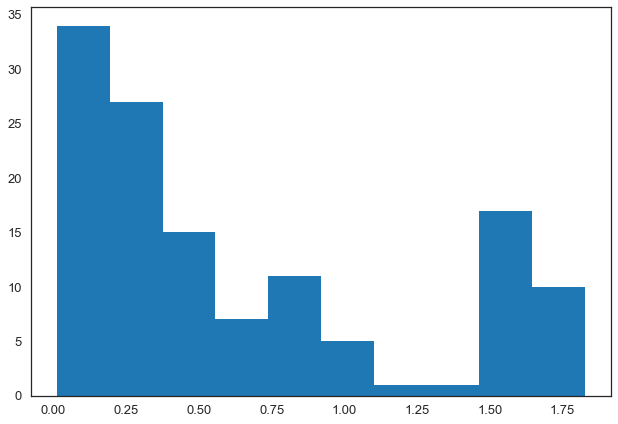

In [41]:
plt.hist(st)

We see, that there are many points not sensitive

In [53]:
indices = np.where(st < 0.5)

In [54]:
diffs_red = np.delete(diffs, obj=indices, axis=1)

Now let's see how the removal of relatively robust datapoints helps:

In [55]:
# calculate RMSE of each realisation.
n = diffs_red.shape[1] # as we have 4 data points for temperature

diffs_sq = diffs_red**2
ssr = diffs_sq.sum(axis=1)
rmse = np.sqrt((diffs_sq.sum(axis=1)/n))

In [56]:
# this is a matrix with all vectors. First 96 columns are differences of the wells, then the column is the SSR, 
# final column is RMSE
tot_diffs = np.column_stack((diffs_red,ssr,rmse))
print(tot_diffs.shape)
# add index to the realizations
ind = np.array(range(tot_diffs.shape[0]))
tot_diffs = np.column_stack((tot_diffs,accepted))

(626, 55)


In [57]:
# Chronological implemntation - start von 1 bis N 
# Can be used here, if samples generated are already in a random order and not correlated.
# That is usually the case with GemPy exports to SHEMAT-Suite.
random.seed(42)
col = 54
Ref = tot_diffs[0,col]
accept = []
P = []
k=0
for i in range(1,tot_diffs.shape[0]):
    if tot_diffs[i,col] < Ref:
        Ref = tot_diffs[i,col]
        accept.append(i)
        
    elif random.random() < np.exp(-(tot_diffs[i,col] - Ref)/(u_T)):
        P.append(np.exp(-(tot_diffs[i,col] - Ref)/(u_T)))
        Ref = tot_diffs[i,col]
        accept.append(i)
        k += 1
print(len(accept))
#print(accept)

351


In [58]:
accepted_reals_Ts = accepted_reals[accept, :]
grav_Ts_prob = probability(accepted_reals_Ts)
grav_Ts_entr = information_entropy(grav_Ts_prob)

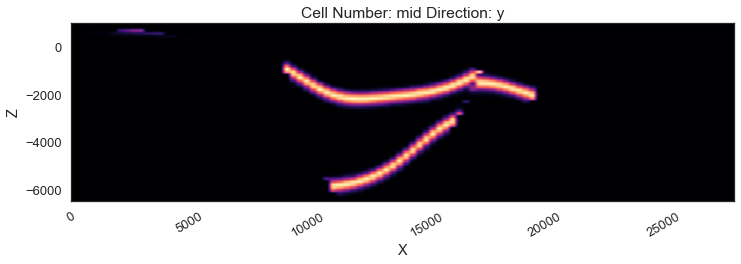

In [59]:
p2dp = gp.plot_2d(geo_model,
                  show_lith=False, show_boundaries=False, show_data=False,
                  regular_grid=grav_Ts_entr,
                  kwargs_regular_grid={'cmap': 'magma',
                                       'norm': None}
                  )
plt.savefig('../imgs/POC_grav_temp_red_posterior_IE.png', dpi=300, bbox_inches='tight')

In [56]:
np.savetxt('../models/20210319_MC_no_middle_filling/accepted_after_temp_rejection_reduced_datapoints', accept)

And we see, temperature data is not sensitive to changes in the PCT-depth.  

But what if we also treat the thermal conductivity as an uncertain parameter?

*Then the rejection is way more rigorous.*

In [60]:
fids = glob.glob('H:PCT_SHEMAT/20210219_MC_outputs/*.h5')

In [70]:
outpath = 'H:PCT_SHEMAT/20210219_MC_outputs\\'
poTemp = []
poUi = []
dicfil = {}
for fn in fids:
    for i in accept:
        if fn == outpath+f"PCT_MC_{i}var_TCt_final.h5":
            dT,dui = extTui(fn, dimension=2, direction='y')
            poTemp.append(dT)
            poUi.append(dui)            
            dicfil[fn.split('/')[-1]] = dui
            

In [71]:
poTempa = np.asarray(poTemp)
poUia = np.asarray(poUi)
accepta = np.asarray(accept)
print(poUia.shape,poTempa.shape,accepta.shape)
np.savetxt('accepted_realisations',accepta,fmt='%i',delimiter=' ',newline='\n')
#np.savetxt('posterior_Temps',poTempa,fmt='%.5f',delimiter=' ',newline='\n',header=" posterior 61 realizations for Temperature")
#np.savetxt('posterior_Uindex',poUia,fmt='%i',delimiter=' ',newline='\n')

(61, 60, 100) (61, 60, 100) (351,)


In [72]:
# calculate mean temperature field and mean posterior uindex
mTemp = np.mean(poTempa,axis=0)
mUi = np.mean(poUia,axis=0)
# import y and z for visualising
plfn = h5py.File('../models/20210219_MC_ensemble/PCT_base_model_final.h5','r')
x = plfn['x'][0,0,:]
y = plfn['y'][0,:,0]
z = plfn['z'][:,0,0]
refT = plfn['temp'][:,25,:]

In [73]:
poUi[0].shape

(60, 100)

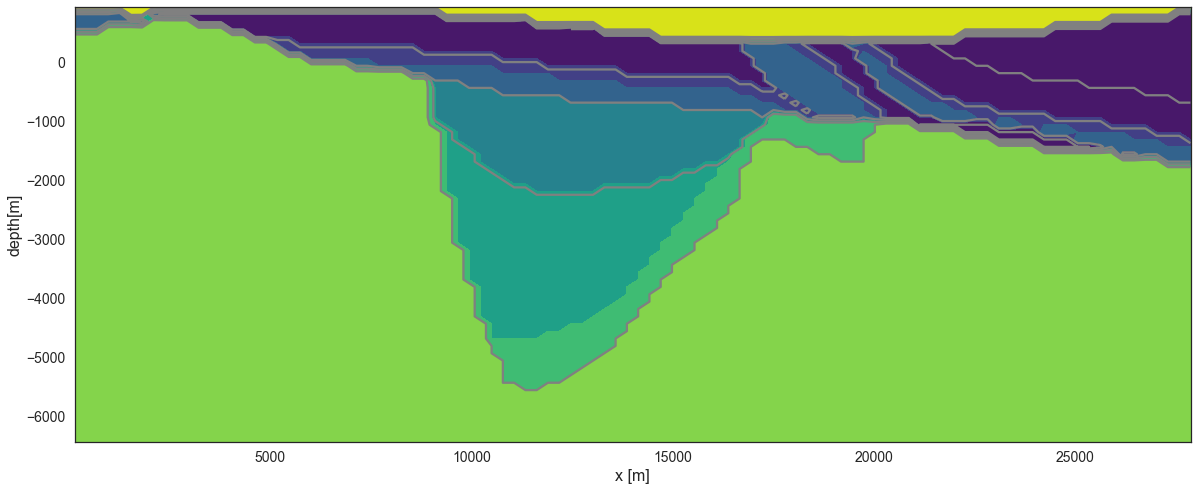

In [79]:
fig = plt.figure(figsize=(20,8))
cs = plt.contourf(x,z-6500.,mUi,cmap='viridis')
plt.contour(x,z-6500.,mUi,5, colors='gray', zorder=1)
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
plt.savefig('../imgs/POC_mean_uindex.png', dpi=300, bbox_inches='tight')

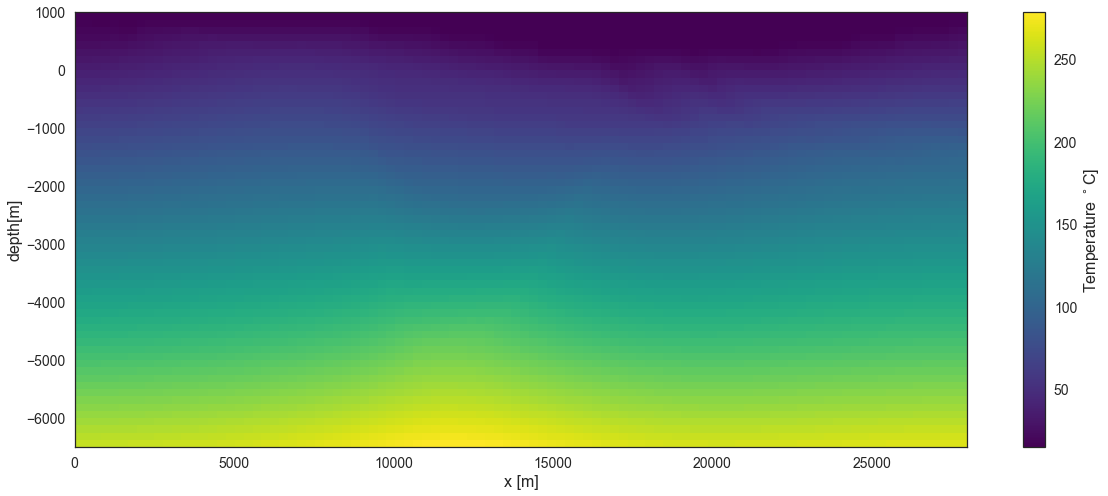

In [80]:
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,mTemp,cmap='viridis', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)

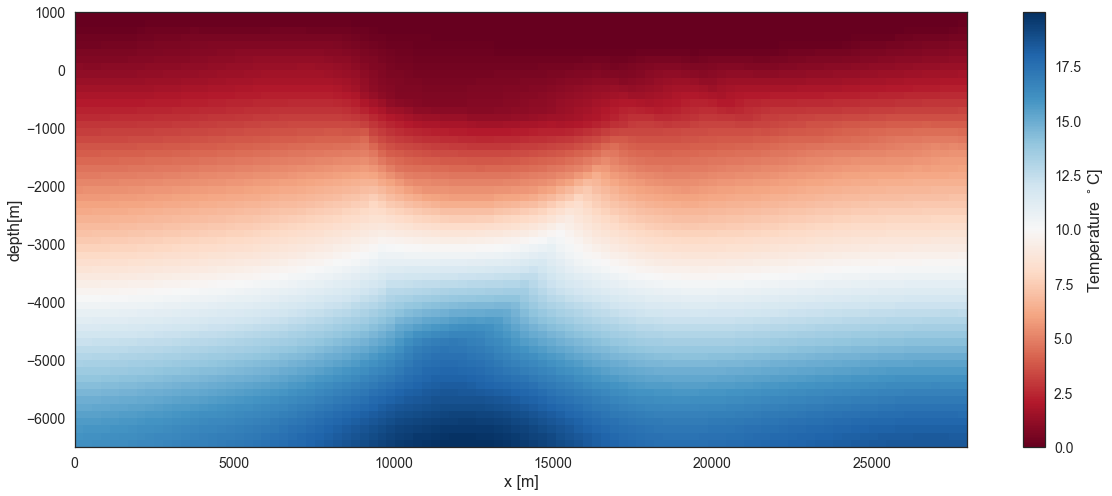

In [86]:
#plot ssr of mean posterior and reference model
fig = plt.figure(figsize=(20,8))
cs = plt.pcolor(x,z-6500.,np.abs((refT-mTemp)),cmap='RdBu', shading='auto')
plt.tick_params(axis='both',labelsize=14)
plt.xlabel('x [m]',fontsize=16)
plt.ylabel('depth[m]',fontsize=16)
cbar = plt.colorbar(cs,orientation='vertical')
cbar.set_label('Temperature $^\circ$C]',fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig('../imgs/POC_absolut_differences_reference_ensemble_mean.png', dpi=300, bbox_inches='tight')